# Geometric Optics: Caustics

A caustic is the envelope of light rays reflected or refracted by a curved surface or object, or the projection of that envelope of rays on another surface. An example of this is the light seen at the bottom of a swimming pool

<img src='http://wwwmpa.mpa-garching.mpg.de/mpa/research/current_research/hl2011-7/fig1.jpg' width=400px>

By performing refraction and ray tracing, an image of a caustic can be visualized for an arbitrary surface (as long as its height and gradients can be expressed as functions of position). This simulation is performed by the [PyCav Optics module](http://pycav.readthedocs.io/en/latest/api/optics/index.html).

In [3]:
#NAME: Caustics
#DESCRIPTION: ...

import numpy as np
from pycav.display import display_animation
import pycav.optics as opt
from pycav.pde import LW_wave_equation
import matplotlib
%matplotlib inline

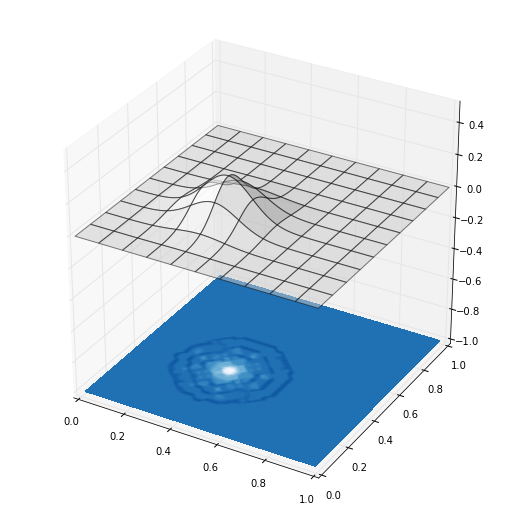

In [4]:
def oneD_gaussian(x,mean,std):
    return np.exp(-((x-mean)**2)/(2*std**2))

def sinc(x,y,x_0,y_0,m):
    r = np.sqrt((x-x_0)**2+(y-y_0)**2)
    return np.sinc(m*r)

def dsinc(x,y,x_0,y_0,m):
    r = np.sqrt((x-x_0)**2+(y-y_0)**2)
    return [(np.cos(np.pi*m*r)/r-np.sinc(m*r)/r)*(x-x_0)/r,(np.cos(np.pi*m*r)/r-np.sinc(m*r)/r)*(y-y_0)/r]

def f(x,y,t):
    f_val  = 0.01*oneD_gaussian(x,0.4,0.1)*oneD_gaussian(y,0.4,0.1)
    #f_val += 0.01*oneD_gaussian(x,0.8,0.1)*oneD_gaussian(y,0.5,0.1)
    #f_val += 0.01*oneD_gaussian(x,0.3,0.2)*oneD_gaussian(y,0.7,0.1)
    return f_val
    
def dfdx(x,y,t):
    df  = -0.01*(x-0.4)*oneD_gaussian(x,0.4,0.1)*oneD_gaussian(y,0.4,0.1)/0.1**2
    #df += -0.01*(x-0.8)*oneD_gaussian(x,0.8,0.1)*oneD_gaussian(y,0.5,0.1)/0.1**2
    #df += -0.01*(x-0.3)*oneD_gaussian(x,0.3,0.2)*oneD_gaussian(y,0.7,0.1)/0.2**2
    #df = 0.01*dsinc(x,y,0.5,0.5,6)[0]
    return df
    
def dfdy(x,y,t):
    df  = -0.01*(y-0.4)*oneD_gaussian(x,0.4,0.1)*oneD_gaussian(y,0.4,0.1)/0.1**2
    #df += -0.01*(y-0.5)*oneD_gaussian(x,0.8,0.1)*oneD_gaussian(y,0.5,0.1)/0.1**2
    #df += -0.01*(y-0.7)*oneD_gaussian(x,0.3,0.2)*oneD_gaussian(y,0.7,0.1)/0.1**2
    #df = 0.01*dsinc(x,y,0.5,0.5,6)[1]
    return df

N_x = 100
N_y = 100
n_arr = [1.,2.]
h = 1.

x,y,rays = opt.ray_grid(N_x,N_y,n_arr,h,f,dfdx,dfdy)

boxsize_x = 0.02
boxsize_y = 0.02
rays_x,rays_y,X,Y,I = opt.single_time_image(rays,boxsize_x,boxsize_y)
opt.caustic_image(x,y,[N_x,N_y],X,Y,I,h,f,0.01,0.25)

### Combining a wave equation solver and the Optics module

Solving the wave equation for given initial conditions can be used as the surface function on which the geometric optics can be performed. The gradient functions can be calculated using central differencing approximations

In [5]:
def twoD_gaussian(XX,YY,mean,std):
    return 0.1*np.exp(-((XX-mean[0])**2+(YY-mean[1])**2)/(2*std**2))

def gradient_2d(XX,YY,mean,std):
    def D(psi_0):
        dfdx = -(XX-mean[0])*twoD_gaussian(XX,YY,mean,std)/std**2
        dfdy = -(YY-mean[1])*twoD_gaussian(XX,YY,mean,std)/std**2
        return dfdx,dfdy
    return D
        
def c_2d(x,y):
    XX,YY = np.meshgrid(x,y, indexing='ij')
    return np.ones_like(XX)

N_x = 100
N_y = 100
N_t = 50

dx = 0.01
x_wave = dx*np.arange(-1,N_x+2)
y_wave = dx*np.arange(-1,N_x+2)

XX,YY = np.meshgrid(x_wave,y_wave,indexing='ij')

psi_0_2d = twoD_gaussian(XX,YY,[0.5,0.45],0.25)
grad_2d = gradient_2d(XX,YY,[0.5,0.45],0.25)

psi_2d,t = LW_wave_equation(psi_0_2d,[x_wave,y_wave],dx,N_t,c_2d, a = 0.6,
                init_grad = grad_2d,bound_cond = 'periodic')

def near_point(x_0,y_0,t_0):
    return (np.where(abs(x_wave-x_0) < dx/2.)[0][0],
            np.where(abs(y_wave-y_0) < dx/2.)[0][0],
            np.where(t == t_0)[0][0])

def wave_f(x_0,y_0,t_0):
    x_idx,y_idx,t_idx = near_point(x_0,y_0,t_0)
    return psi_2d[x_idx,y_idx,t_idx]

def wave_dfdx(x_0,y_0,t_0):
    x_idx,y_idx,t_idx = near_point(x_0,y_0,t_0)
    return (psi_2d[x_idx+1,y_idx,t_idx]-psi_2d[x_idx-1,y_idx,t_idx])/(2*dx)
    
def wave_dfdy(x_0,y_0,t_0):
    x_idx,y_idx,t_idx = near_point(x_0,y_0,t_0)
    return (psi_2d[x_idx,y_idx+1,t_idx]-psi_2d[x_idx,y_idx-1,t_idx])/(2*dx)

In [6]:
n_arr = [1.,1.3]
h = 1.

x,y,rays = opt.ray_grid(N_x,N_y,n_arr,h,wave_f,wave_dfdx,wave_dfdy)

boxsize_x = 0.02
boxsize_y = 0.02
X_t,Y_t,I_t = opt.evolve(rays,t,boxsize_x,boxsize_y)

In [7]:
animation = opt.caustic_anim(x,y,t,[N_x,N_y],X_t,Y_t,I_t,h,wave_f,0.1,0.25);
display_animation(animation)